In [17]:
# importing necessary packages 
from typing import Optional, Tuple, List
import math, time, itertools
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, LogLocator, ScalarFormatter
from matplotlib.lines import Line2D

#importing sklearn packages 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

#for reprodciliblity
RANDOM_SEED = 42
DPI = 120
OUTLIER_LABEL = 999

# repeatation paramters 
REPEATS = 8
BOOT_B = 2000
PERM_N = 10000
BOOT_SAMPLES_B = 200

rng_global = np.random.default_rng(RANDOM_SEED)
now = time.perf_counter

# Pandas display (prints full tables)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

#  style and plot
mpl.rcParams.update({
    "figure.dpi": DPI,
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 15,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.grid": True,
    "grid.linestyle": ":",
    "grid.alpha": 0.6,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

palette = {"kmeans":"#0072B2","agg-ward":"#E69F00","gmm":"#009E73","dbscan":"#D55E00"}
markers = {"kmeans":"o","agg-ward":"s","gmm":"^","dbscan":"D"}
linestyles = {"kmeans":"-","agg-ward":"--","gmm":"-.","dbscan":":"}
LINEWIDTH = 2.2
SCATTER_S = 46
MEW = 0.9

def style_axes(ax, integer_x=False, log_y=False):
    if integer_x:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if log_y:
        ax.set_yscale("log")
        ax.yaxis.set_major_locator(LogLocator(base=10, subs=(1, 2, 5)))
        ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(1, 10) * 0.1, numticks=12))
        ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.grid(True, axis="y", which="major", linestyle=":", linewidth=0.7, alpha=0.35)
    ax.margins(x=0.03, y=0.06)

def add_method_legend(ax, loc="upper left", anchor=(1.02, 1.0)):
    handles=[]
    for m in ["kmeans","agg-ward","gmm","dbscan"]:
        handles.append(Line2D([0],[0], color=palette[m], linestyle=linestyles[m],
                              linewidth=LINEWIDTH, marker=markers[m],
                              markersize=math.sqrt(SCATTER_S), markerfacecolor=palette[m],
                              markeredgecolor="black", markeredgewidth=MEW, label=m))
    ax.legend(handles=handles, frameon=False, bbox_to_anchor=anchor, loc=loc, borderaxespad=0.)

def show_table(df: pd.DataFrame, title: str):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))
    print(df.to_string(index=False))


In [28]:
# defining functions for condifidence interval
def mean_ci(vals: np.ndarray, alpha: float = 0.05, B: int = BOOT_B, seed: int = 0) -> Tuple[float,float,float]:
    vals = np.asarray(vals, float)
    if len(vals) <= 1:
        x = float(vals.mean())
        return x, x, x
    rs = np.random.default_rng(seed)
    means = [rs.choice(vals, size=len(vals), replace=True).mean() for _ in range(B)]
    lo, hi = np.quantile(means, [alpha/2, 1-alpha/2])
    return float(vals.mean()), float(lo), float(hi)

def paired_permutation_pvalues(a: np.ndarray, b: np.ndarray, n_perm: int = PERM_N, seed: int = 0) -> float:
    a = np.asarray(a, float); b = np.asarray(b, float)
    assert len(a) == len(b) and len(a) > 0
    d = a - b
    obs = abs(d.mean())
    if len(d) == 1:
        return 1.0
    rs = np.random.default_rng(seed)
    cnt = 0
    for _ in range(n_perm):
        signs = rs.choice([-1.0, 1.0], size=len(d))
        perm_mean = abs((signs * d).mean())
        if perm_mean >= obs:
            cnt += 1
    return (cnt + 1) / (n_perm + 1)

def summarize_with_ci(df: pd.DataFrame, key_col: str, method_col: str, value_cols: List[str]) -> pd.DataFrame:
    rows=[]
    for key, subk in df.groupby(key_col):
        for m, subm in subk.groupby(method_col):
            rec = {key_col: key, "method": m}
            for vc in value_cols:
                vals = subm[vc].values
                mu, lo, hi = mean_ci(vals, seed=hash((key, m, vc)) % (2**32-1))
                rec[f"{vc}_mean"] = mu
                rec[f"{vc}_lo"]   = lo
                rec[f"{vc}_hi"]   = hi
            rows.append(rec)
    return pd.DataFrame(rows)

def pairwise_pvals(df: pd.DataFrame, key_col: str, method_col: str, metric_col: str, methods: List[str]) -> pd.DataFrame:
    out=[]
    for key, subk in df.groupby(key_col):
        per = {}
        for m in methods:
            sm = subk[subk[method_col]==m].sort_values("repeat")
            per[m] = sm[metric_col].values
        for a,b in itertools.combinations(methods, 2):
            if len(per[a])>0 and len(per[a])==len(per[b]):
                p = paired_permutation_pvalues(per[a], per[b], seed=hash((key,a,b,metric_col)) % (2**32-1))
            else:
                p = np.nan
            out.append({key_col:key, "metric":metric_col, "method_a":a, "method_b":b, "p_value":p})
    return pd.DataFrame(out)

def plot_with_ci(ax, x_vals, stats_df, x_key, y_key, label, color, line, marker):
    sub = stats_df.sort_values(x_key)
    mean = sub[f"{y_key}_mean"].values
    lo   = sub[f"{y_key}_lo"].values
    hi   = sub[f"{y_key}_hi"].values
    yerr = np.vstack([mean - lo, hi - mean])
    ax.plot(x_vals, mean, color=color, linestyle=line, linewidth=LINEWIDTH, label=label)
    ax.errorbar(x_vals, mean, yerr=yerr, fmt=marker, color=color,
                markersize=math.sqrt(SCATTER_S), markeredgecolor="black",
                markeredgewidth=MEW, linewidth=0, zorder=3)


In [29]:
# calculating sihoutte score without noise and seperate definition for experiment 2 (outliers)
def silhouette_safe(X: np.ndarray, labels: np.ndarray) -> float:
    z = np.asarray(labels)
    m = (z != -1)
    if m.sum() == 0 or len(np.unique(z[m])) < 2:
        return np.nan
    return float(silhouette_score(X[m], z[m]))

def dbi_safe(X: np.ndarray, labels: np.ndarray) -> float:
    z = np.asarray(labels)
    m = (z != -1)
    if m.sum() == 0 or len(np.unique(z[m])) < 2:
        return np.nan
    return float(davies_bouldin_score(X[m], z[m]))

def ch_safe(X: np.ndarray, labels: np.ndarray) -> float:
    z = np.asarray(labels)
    m = (z != -1)
    if m.sum() == 0 or len(np.unique(z[m])) < 2:
        return np.nan
    return float(calinski_harabasz_score(X[m], z[m]))

def silhouette_on_mask(X: np.ndarray, labels: np.ndarray, mask: np.ndarray) -> float:
    if mask.sum() == 0:
        return np.nan
    labs = np.asarray(labels)[mask]
    m2 = (labs != -1)
    if m2.sum() == 0 or len(np.unique(labs[m2])) < 2:
        return np.nan
    return float(silhouette_score(X[mask][m2], labs[m2]))

def dbi_on_mask(X: np.ndarray, labels: np.ndarray, mask: np.ndarray) -> float:
    if mask.sum() == 0:
        return np.nan
    labs = np.asarray(labels)[mask]
    m2 = (labs != -1)
    if m2.sum() == 0 or len(np.unique(labs[m2])) < 2:
        return np.nan
    return float(davies_bouldin_score(X[mask][m2], labs[m2]))

def ch_on_mask(X: np.ndarray, labels: np.ndarray, mask: np.ndarray) -> float:
    if mask.sum() == 0:
        return np.nan
    labs = np.asarray(labels)[mask]
    m2 = (labs != -1)
    if m2.sum() == 0 or len(np.unique(labs[m2])) < 2:
        return np.nan
    return float(calinski_harabasz_score(X[mask][m2], labs[m2]))


In [30]:
# defening mahalanobis for exp1 (seperation)
def mahalanobis_separation(X: np.ndarray, y: np.ndarray, reg: float = 1e-6):
    y = np.asarray(y)
    mask = (y != OUTLIER_LABEL)
    X = np.asarray(X)[mask]
    y = y[mask]
    classes = np.unique(y)
    k = len(classes)
    if k < 2:
        return np.nan, np.nan, np.array([])
    means = [X[y == c].mean(axis=0) for c in classes]

    d = X.shape[1]
    Sw = np.zeros((d, d), dtype=float)
    n_total = 0
    for c in classes:
        Xi = X[y == c]
        n = Xi.shape[0]
        if n <= 1:
            continue
        C = np.cov(Xi, rowvar=False, bias=False)
        Sw += (n - 1) * C
        n_total += (n - 1)
    if n_total > 0:
        Sw /= n_total
    else:
        Sw = np.cov(X, rowvar=False, bias=False)

    Sw += reg * np.eye(Sw.shape[0])
    Sw_inv = np.linalg.pinv(Sw)

    dists = []
    for i in range(k):
        for j in range(i + 1, k):
            diff = means[i] - means[j]
            dmh = float(np.sqrt(diff @ Sw_inv @ diff))
            dists.append(dmh)
    dists = np.asarray(dists, dtype=float)
    return float(np.mean(dists)), float(np.min(dists)), dists


In [31]:
# all clustering methods function
EPS_MODE = "median_mix"   # "median_mix", "p80", "median1p3", "elbow"

def estimate_dbscan_eps(X: np.ndarray, k_neighbors=10, mode: str = EPS_MODE, p: float = 0.80):
    nn = NearestNeighbors(n_neighbors=k_neighbors).fit(X)
    kd = np.sort(nn.kneighbors(X)[0][:, -1])
    def _elbow(distances: np.ndarray) -> float:
        try:
            from scipy.ndimage import uniform_filter1d
            smooth = uniform_filter1d(distances.astype(float),
                                      size=max(3, min(21, len(distances)//20)))
            if len(smooth) >= 3:
                sec = np.diff(smooth, n=2)
                idx = int(np.argmax(sec) + 1)
                idx = max(0, min(idx, len(distances)-1))
                return float(distances[idx])
        except Exception:
            pass
        return float(np.quantile(distances, 0.80))
    if mode == "p80":
        eps = float(np.quantile(kd, p))
    elif mode == "median1p3":
        eps = float(np.median(kd) * 1.3)
    elif mode == "elbow":
        eps = _elbow(kd)
    else:
        cand = [np.quantile(kd, 0.80), np.median(kd)*1.2, _elbow(kd)]
        eps = float(np.median(cand))
    return eps, kd

def run_clustering_methods(X: np.ndarray, n_clusters: int = 3, seed: int = RANDOM_SEED,
                           dbscan_eps: Optional[float] = None, db_min_samples: int = 10):
    results = []
    t0 = now()
    km = KMeans(n_clusters=n_clusters, n_init="auto", algorithm="elkan",
                max_iter=500, random_state=seed).fit(X)
    results.append(("kmeans", km.labels_, now() - t0))
    t0 = now()
    ag = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(X)
    results.append(("agg-ward", ag.labels_, now() - t0))
    t0 = now()
    gm = GaussianMixture(n_components=n_clusters, covariance_type="full",
                         n_init=5, reg_covar=1e-6, max_iter=500,
                         random_state=seed).fit(X)
    results.append(("gmm", gm.predict(X), now() - t0))
    if dbscan_eps is None:
        dbscan_eps, _ = estimate_dbscan_eps(X, k_neighbors=db_min_samples)
    t0 = now()
    db = DBSCAN(eps=dbscan_eps, min_samples=db_min_samples).fit(X)
    results.append(("dbscan", db.labels_, now() - t0))
    return results, dbscan_eps

def evaluate_methods_standard(X: np.ndarray, y_true: np.ndarray, method_runs):
    rows=[]
    for name, labels, runtime in method_runs:
        rows.append({
            "method": name,
            "ARI": adjusted_rand_score(y_true, labels),
            "Silhouette": silhouette_safe(X, labels),
            "DBI": dbi_safe(X, labels),
            "CH": ch_safe(X, labels),
            "runtime_s": runtime,
        })
    return rows


In [32]:
# adding strectched out blob, outlier, feature noise functions to use later
def create_stretched_out_blobs(n_samples=1500, n_features=50, n_clusters=3,
                               cluster_std=1.6, center_scale=3.2, aniso_strength=4.0,
                               seed: int = RANDOM_SEED):
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters,
                      cluster_std=cluster_std, random_state=seed,
                      center_box=(-center_scale, center_scale))
    r = np.random.default_rng(seed)
    X_out = np.empty_like(X)
    for c in range(n_clusters):
        M = r.normal(size=(n_features, n_features))
        Q, _ = np.linalg.qr(M)
        scales = np.geomspace(1.0, aniso_strength, n_features)
        A = Q @ np.diag(scales)
        Xi = X[y == c]
        X_out[y == c] = Xi @ A.T / math.sqrt(aniso_strength)
    return X_out, y

def add_boundary_outliers(X: np.ndarray, y: np.ndarray, fraction=0.1, seed: int = RANDOM_SEED):
    if fraction <= 0:
        return X, y
    r = np.random.default_rng(seed)
    n_out = int(round(len(X) * fraction))
    centroids = np.vstack([X[y == c].mean(0) for c in np.unique(y)])
    pairs = [(i, j) for i in range(len(centroids)) for j in range(i + 1, len(centroids))]
    outliers = []
    for _ in range(n_out):
        i, j = pairs[r.integers(len(pairs))]
        midpoint = 0.5 * (centroids[i] + centroids[j])
        spread = 0.6 * np.linalg.norm(centroids[i] - centroids[j]) / X.shape[1]
        outliers.append(midpoint + r.normal(scale=spread, size=X.shape[1]))
    outliers = np.asarray(outliers)
    X2 = np.vstack([X, outliers])
    y2 = np.concatenate([y, np.full(n_out, OUTLIER_LABEL, dtype=int)])
    return X2, y2

def add_feature_noise(X: np.ndarray, sigma=0.2, seed: int = RANDOM_SEED):
    r = np.random.default_rng(seed)
    return X + r.normal(scale=sigma, size=X.shape)


D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread


Experiment-1: DBSCAN eps across @ std=1.6
      eps      ARI  Silhouette      DBI         CH
10.356404 0.000000         NaN      NaN        NaN
10.931760 0.000000         NaN      NaN        NaN
11.507116 0.000000         NaN      NaN        NaN
12.082471 0.001029    0.193926 2.103335  21.488055
12.657827 0.014264    0.144392 2.400541  43.198614
13.233183 0.175690    0.239281 1.950492 202.892501
13.808539 0.576907    0.321837 1.272882 470.812106
14.383894 0.822236    0.312438 1.303818 538.469179
14.959250 0.938814    0.306708 1.323113 565.239571
15.534606 0.974789    0.304774 1.329692 573.086267
16.109962 0.991976    0.303675 1.333144 576.049784
16.685318 0.569876    0.220151 1.662217 438.987697
17.260673 0.000000         NaN      NaN        NaN
17.836029 0.000000         NaN      NaN        NaN
18.411385 0.000000         NaN      NaN        NaN
18.986741 0.000000         NaN      NaN        NaN
19.562096 0.000000         NaN      NaN        NaN
20.137452 0.000000         NaN      NaN

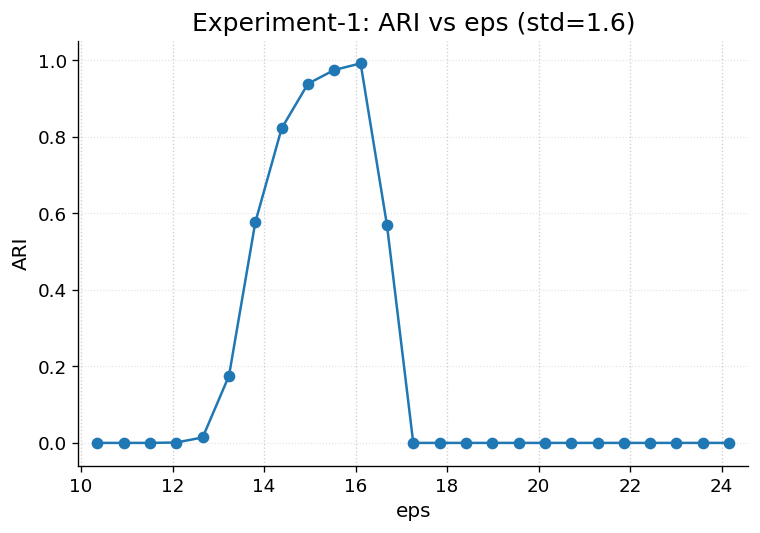

D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread


Experiment-1: Raw repeats (all metrics)
 repeat  std  maha_mean  maha_min   method           ARI  Silhouette      DBI          CH  runtime_s
      0  0.8  21.635788 20.578127   kmeans  1.000000e+00    0.563447 0.682965 2244.471897   0.150344
      0  0.8  21.635788 20.578127 agg-ward  1.000000e+00    0.563447 0.682965 2244.471897   0.518459
      0  0.8  21.635788 20.578127      gmm  1.000000e+00    0.563447 0.682965 2244.471897   3.362142
      0  0.8  21.635788 20.578127   dbscan  9.990003e-01    0.563595 0.682549 2245.296767   0.447257
      1  0.8  21.885095 20.235921   kmeans  1.000000e+00    0.548713 0.709150 2140.391737   0.126364
      1  0.8  21.885095 20.235921 agg-ward  1.000000e+00    0.548713 0.709150 2140.391737   0.471618
      1  0.8  21.885095 20.235921      gmm  1.000000e+00    0.548713 0.709150 2140.391737   3.762938
      1  0.8  21.885095 20.235921   dbscan  9.779111e-01    0.550662 0.705169 2132.179237   0.476146
      2  0.8  22.410226 21.041312   kmeans  1.0000

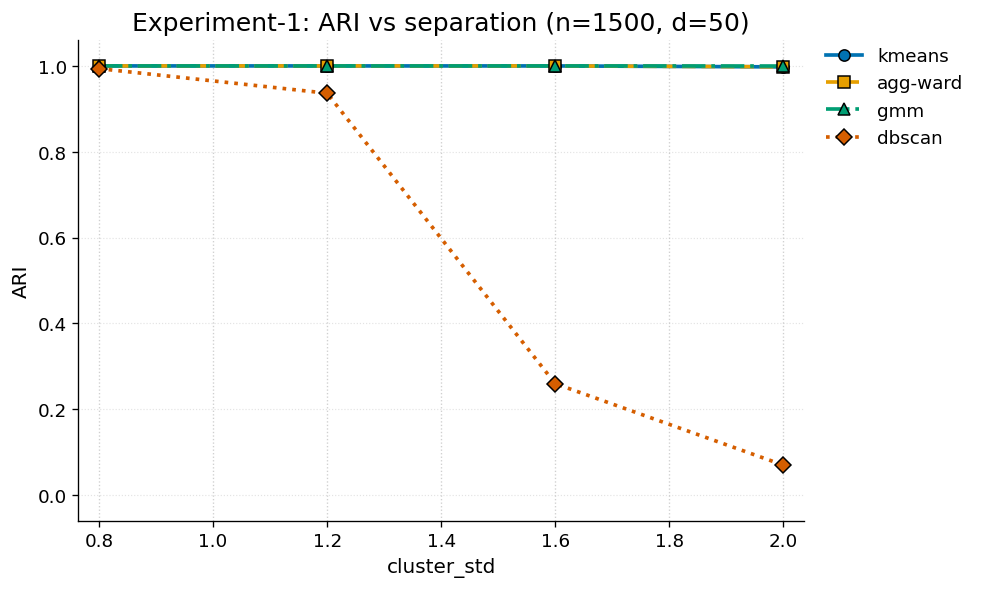

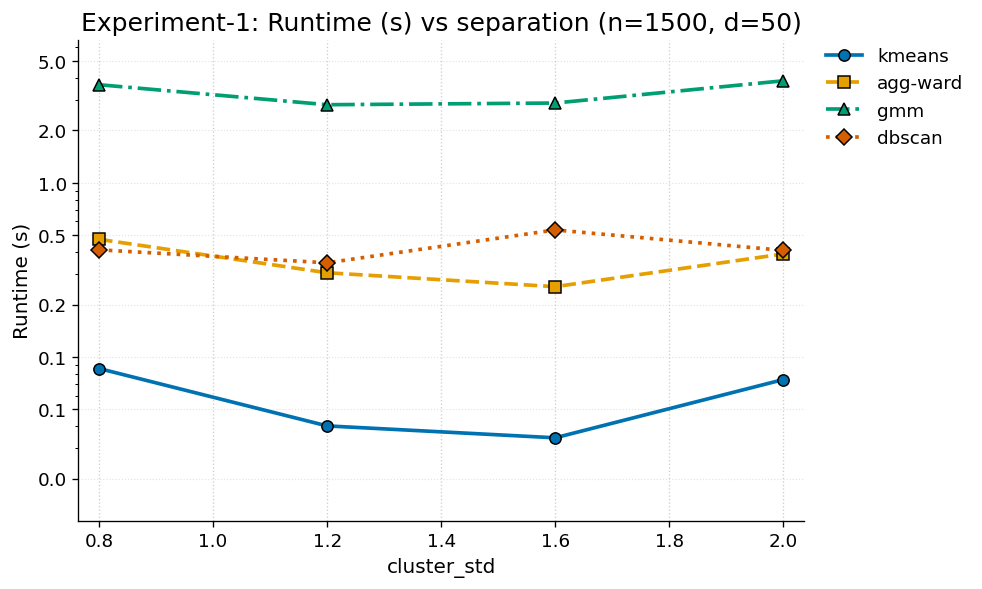

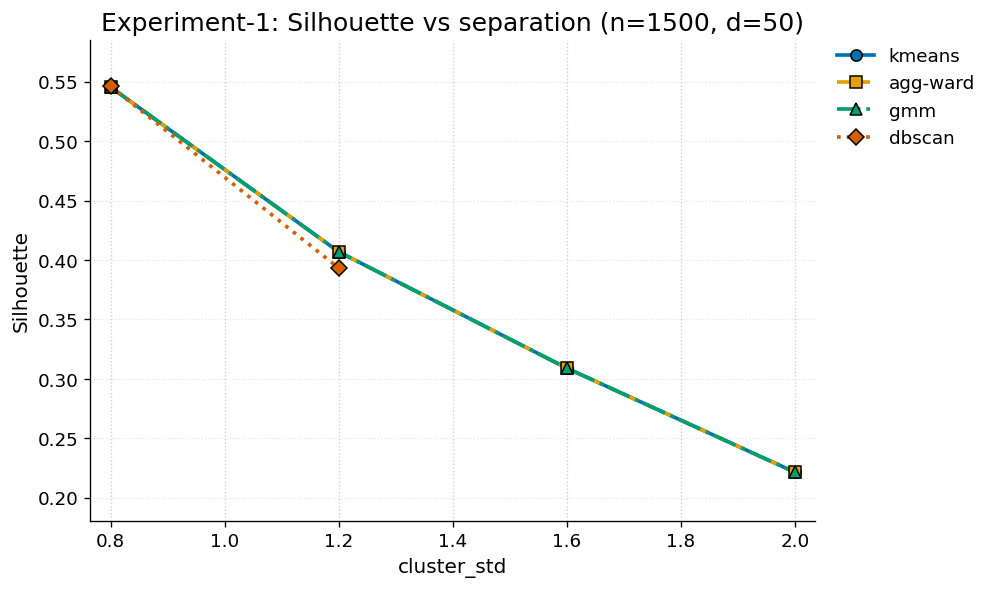

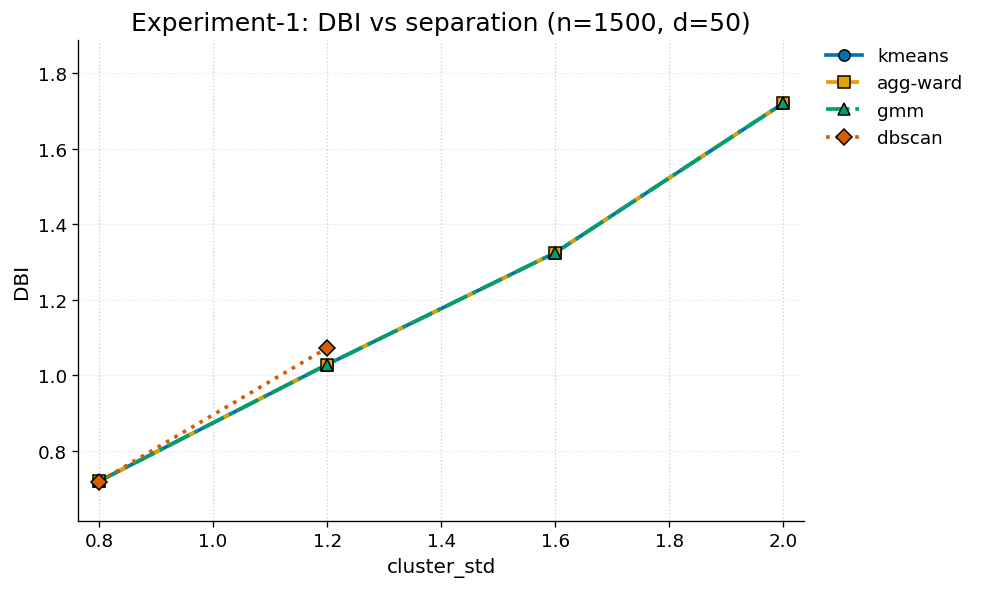

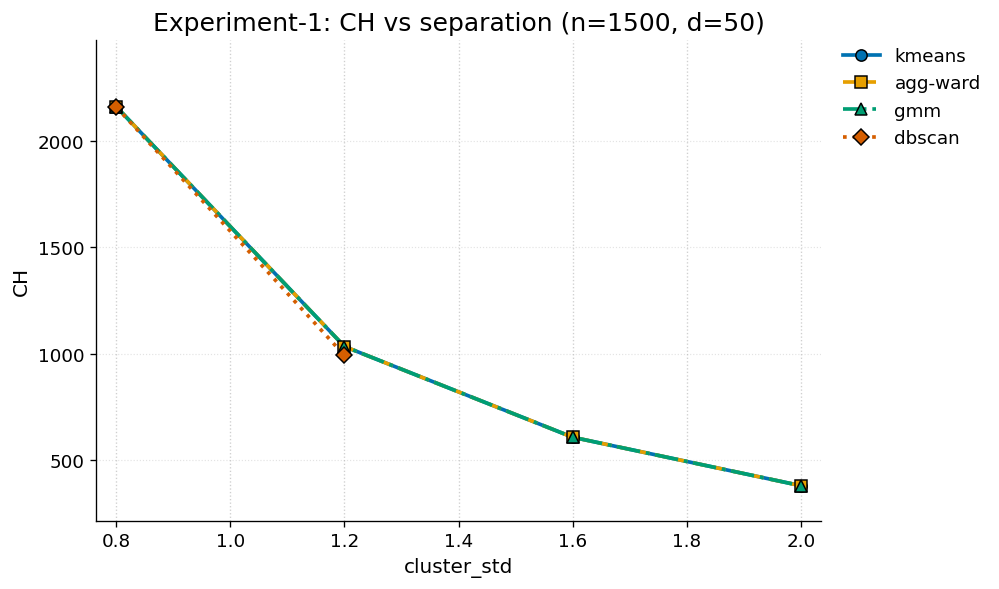

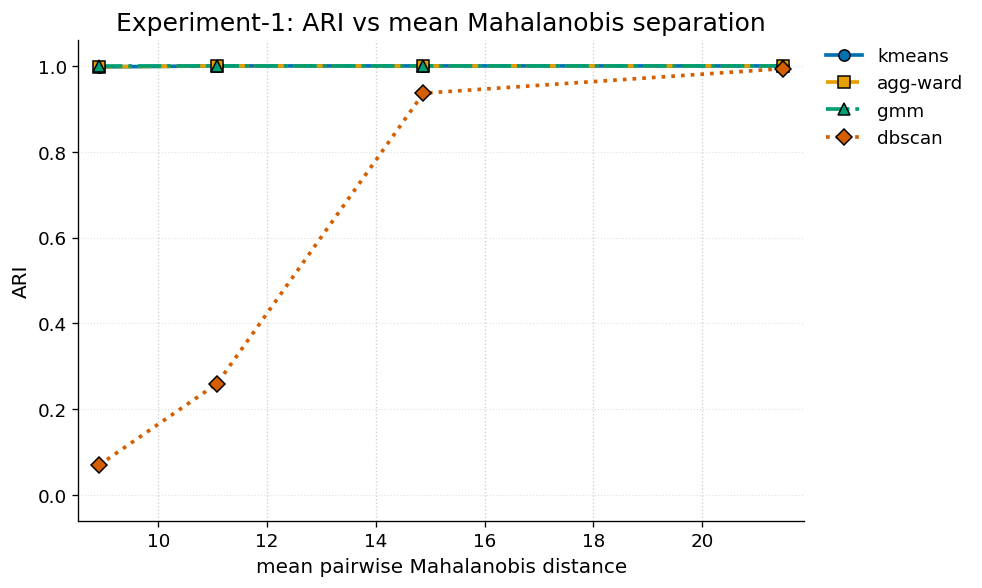

In [33]:

# Experiment 1 : Separation (cluster_std), n=1500, d=50
n_features = 50
n_samples = 1500
n_clusters = 3
std_values = [0.8, 1.2, 1.6, 2.0]

rows = []
eps_sweep_done = False

for std in std_values:
    for r in range(REPEATS):
        seed = RANDOM_SEED + 1000*r + int(100*std)
        X, y = create_stretched_out_blobs(n_samples=n_samples, n_features=n_features,
                                          n_clusters=n_clusters, cluster_std=std,
                                          center_scale=3.0, aniso_strength=4.0,
                                          seed=seed)
        maha_mean, maha_min, _ = mahalanobis_separation(X, y)
        runs, _ = run_clustering_methods(X, n_clusters=n_clusters, seed=seed)
        eval_rows = evaluate_methods_standard(X, y, runs)
        for rec in eval_rows:
            rows.append({"repeat": r, "std": std, "maha_mean": maha_mean, "maha_min": maha_min, **rec})

        # One DBSCAN eps across at std=1.6 (first repeat)
        if (not eps_sweep_done) and abs(std - 1.6) < 1e-12 and r == 0:
            eps0, _ = estimate_dbscan_eps(X, k_neighbors=10)
            eps_grid = np.linspace(0.6 * eps0, 1.4 * eps0, 25)
            sweep_rows = []
            for eps in eps_grid:
                labels = DBSCAN(eps=float(eps), min_samples=10).fit_predict(X)
                sweep_rows.append({
                    "eps": float(eps),
                    "ARI": adjusted_rand_score(y, labels),
                    "Silhouette": silhouette_safe(X, labels),
                    "DBI": dbi_safe(X, labels),
                    "CH": ch_safe(X, labels),
                })
            sweep_df = pd.DataFrame(sweep_rows)
            show_table(sweep_df, "Experiment-1: DBSCAN eps across @ std=1.6")
            fig, ax = plt.subplots(figsize=(7.2,4.6))
            ax.plot(sweep_df["eps"], sweep_df["ARI"], marker="o")
            ax.set_title("Experiment-1: ARI vs eps (std=1.6)")
            ax.set_xlabel("eps"); ax.set_ylabel("ARI"); style_axes(ax)
            plt.show()
            eps_sweep_done = True

exp1_df = pd.DataFrame(rows)
show_table(exp1_df, "Experiment-1: Raw repeats (all metrics)")

exp1_sum = summarize_with_ci(exp1_df, key_col="std", method_col="method",
                             value_cols=["ARI","Silhouette","DBI","CH","runtime_s"])
show_table(exp1_sum.sort_values(["method","std"]), "Experiment-1: Summary (mean±CI cols)")

exp1_p = pairwise_pvals(exp1_df, key_col="std", method_col="method",
                        metric_col="ARI", methods=["kmeans","agg-ward","gmm","dbscan"])
show_table(exp1_p.sort_values(["metric","method_a","method_b","std"]), "Experiment-1: Pairwise p-values (ARI)")

# MAIN figures
def _line_ci_exp1(metric, ylab, log_y=False):
    fig, ax = plt.subplots(figsize=(7.8,5.2))
    for m in ["kmeans","agg-ward","gmm","dbscan"]:
        stats = exp1_sum[exp1_sum["method"]==m].copy().sort_values("std")
        plot_with_ci(ax, stats["std"].values, stats, "std", metric, m,
                     palette[m], linestyles[m], markers[m])
    ax.set_title(f"Experiment-1: {ylab} vs separation (n=1500, d=50)")
    ax.set_xlabel("cluster_std"); ax.set_ylabel(ylab)
    style_axes(ax, log_y=log_y); add_method_legend(ax); plt.show()

_line_ci_exp1("ARI","ARI")
_line_ci_exp1("runtime_s","Runtime (s)", log_y=True)
_line_ci_exp1("Silhouette","Silhouette")
_line_ci_exp1("DBI","DBI")
_line_ci_exp1("CH","CH")

# ARI vs Mahalanobis
fig, ax = plt.subplots(figsize=(7.8,5.2))
maha_map = exp1_df.groupby("std")["maha_mean"].mean().to_dict()
for m in ["kmeans","agg-ward","gmm","dbscan"]:
    stats = exp1_sum[exp1_sum["method"]==m].copy()
    stats["maha"] = stats["std"].map(maha_map)
    stats = stats.sort_values("maha")
    plot_with_ci(ax, stats["maha"].values, stats.rename(columns={"maha":"maha"}), "maha", "ARI", m,
                 palette[m], linestyles[m], markers[m])
ax.set_title("Experiment-1: ARI vs mean Mahalanobis separation")
ax.set_xlabel("mean pairwise Mahalanobis distance"); ax.set_ylabel("ARI")
style_axes(ax); add_method_legend(ax); plt.show()


D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread


Experiment-2: DBSCAN eps across @ 10% outliers
      eps   ARI_all  ARI_inliers  Silhouette_inliers  DBI_inliers  CH_inliers
 9.080031  0.145120     0.000000                 NaN          NaN         NaN
 9.584477  0.144949    -0.000002                 NaN          NaN         NaN
10.088923  0.144949    -0.000002                 NaN          NaN         NaN
10.593369  0.144615     0.000005                 NaN          NaN         NaN
11.097815  0.143620     0.000038                 NaN          NaN         NaN
11.602261  0.140830     0.000145            0.209128     1.420979   10.494142
12.106707  0.130935     0.000215                 NaN          NaN         NaN
12.611154  0.084694     0.002218                 NaN          NaN         NaN
13.115600  0.025200     0.005894                 NaN          NaN         NaN
13.620046 -0.007477     0.004397                 NaN          NaN         NaN
14.124492 -0.011302    -0.000045                 NaN          NaN         NaN
14.628938 -0.006

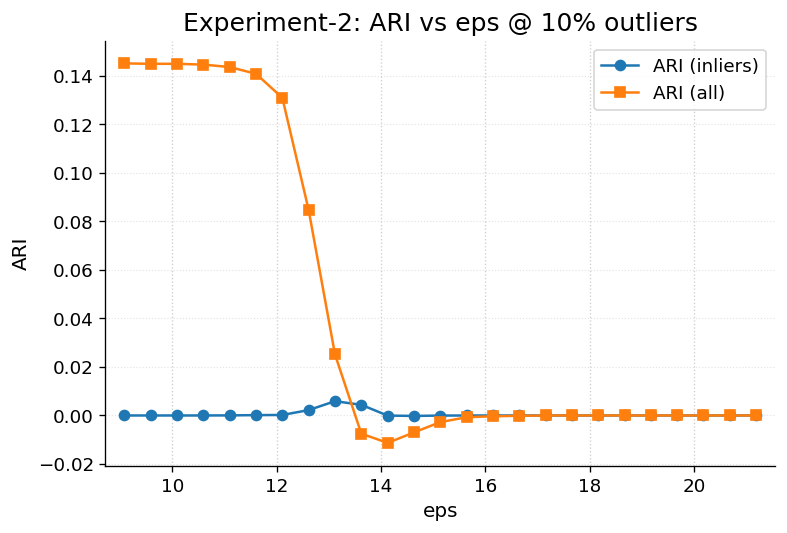

D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread


Experiment-2: Raw repeats (all metrics)
 repeat   method  outlier_frac   ARI_all  ARI_inliers  Silhouette_inliers  DBI_inliers  CH_inliers  runtime_s
      0   kmeans          0.00  1.000000     1.000000            0.256202     1.543640  453.974160   0.020913
      0 agg-ward          0.00  1.000000     1.000000            0.256202     1.543640  453.974160   0.196193
      0      gmm          0.00  1.000000     1.000000            0.256202     1.543640  453.974160   1.467666
      0   dbscan          0.00  0.000000     0.000000                 NaN          NaN         NaN   0.370876
      1   kmeans          0.00  1.000000     1.000000            0.282926     1.429783  556.333681   0.017092
      1 agg-ward          0.00  1.000000     1.000000            0.282926     1.429783  556.333681   0.217022
      1      gmm          0.00  1.000000     1.000000            0.282926     1.429783  556.333681   1.471649
      1   dbscan          0.00  0.000000     0.000000                 NaN      

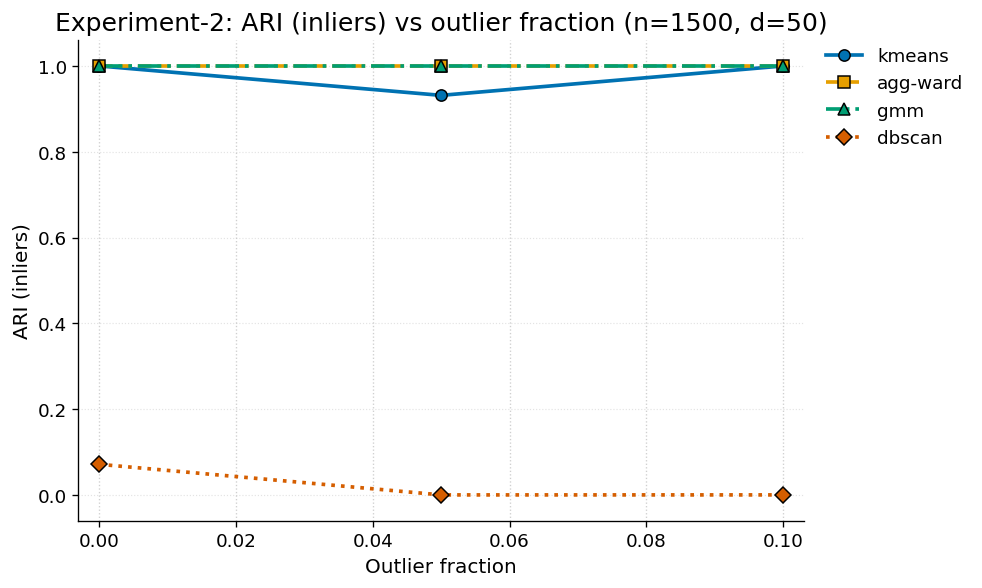

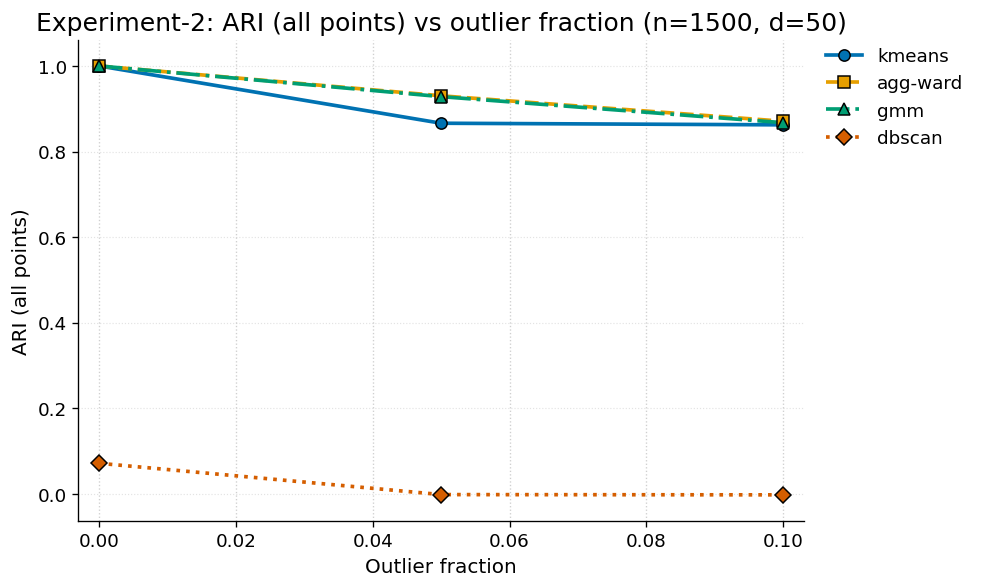

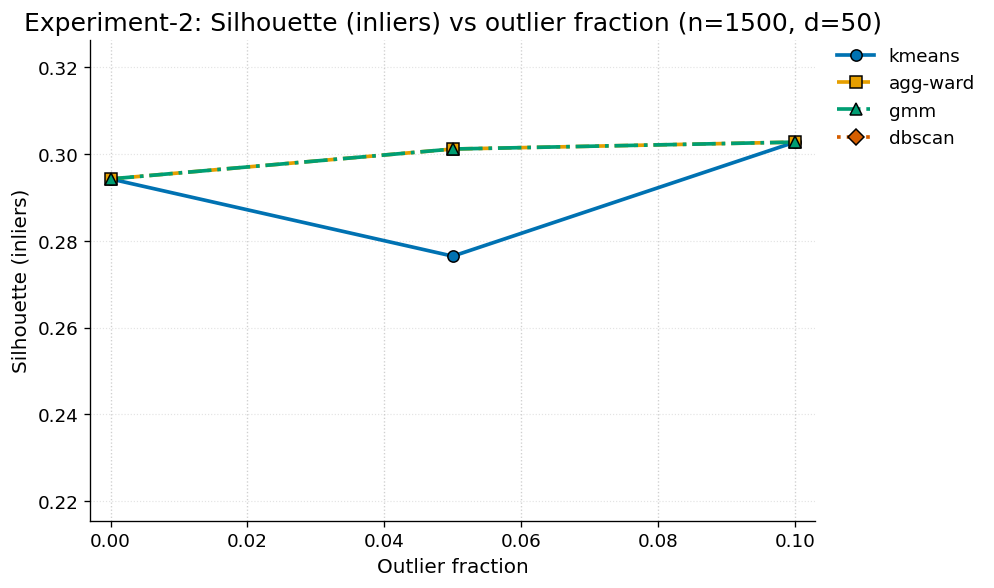

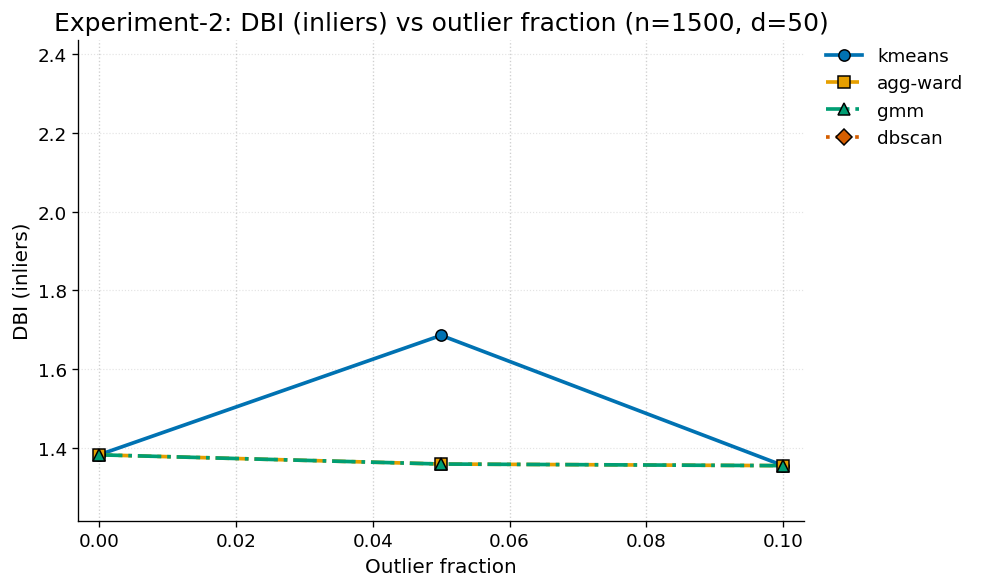

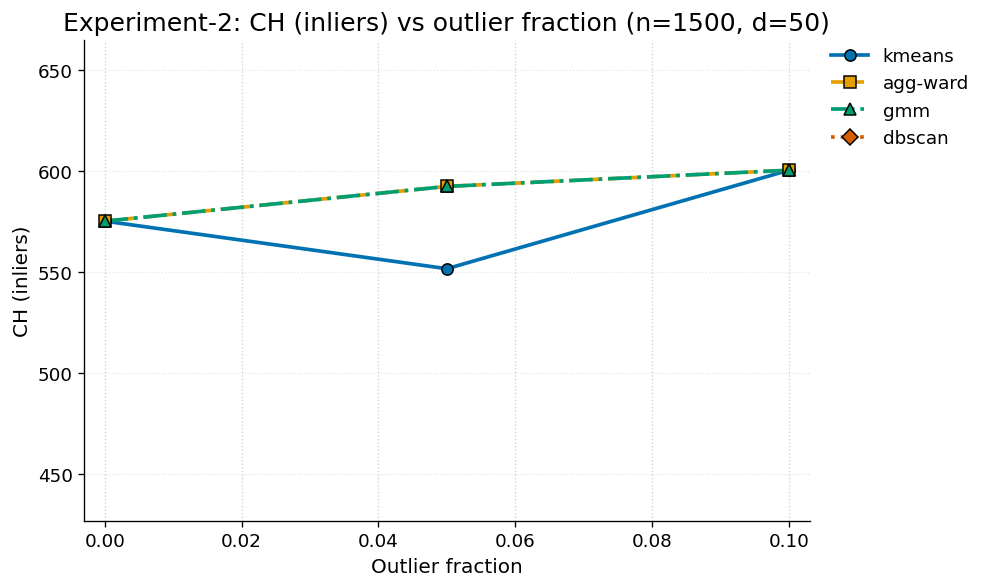

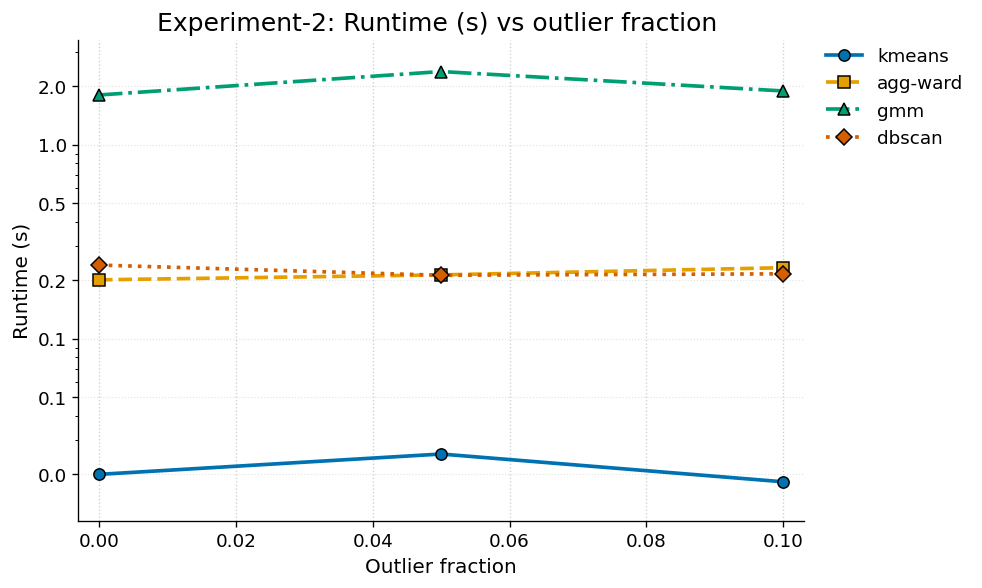

In [34]:

# Experiment 2 — Outliers with fixed standard deviation
n_features = 50
n_samples = 1500
n_clusters = 3
base_std = 1.6
outlier_fracs = [0.0, 0.05, 0.10]

rows = []
sweep_shown = False

for frac in outlier_fracs:
    for r in range(REPEATS):
        seed = RANDOM_SEED + 2000*r + int(100*frac)
        X0, y0 = create_stretched_out_blobs(n_samples=n_samples, n_features=n_features,
                                            n_clusters=n_clusters, cluster_std=base_std,
                                            center_scale=3.0, aniso_strength=4.0, seed=seed)
        X, y = add_boundary_outliers(X0, y0, fraction=frac, seed=seed)
        mask_inliers = (y != OUTLIER_LABEL)

        runs, _ = run_clustering_methods(X, n_clusters=n_clusters, seed=seed)
        for name, labels, rt in runs:
            rows.append({
                "repeat": r, "method": name, "outlier_frac": frac,
                "ARI_all": adjusted_rand_score(y, labels),
                "ARI_inliers": adjusted_rand_score(y[mask_inliers], labels[mask_inliers]),
                "Silhouette_inliers": silhouette_on_mask(X, labels, mask_inliers),
                "DBI_inliers": dbi_on_mask(X, labels, mask_inliers),
                "CH_inliers": ch_on_mask(X, labels, mask_inliers),
                "runtime_s": rt,
            })

        if (not sweep_shown) and abs(frac - 0.10) < 1e-12 and r == 0:
            eps0, _ = estimate_dbscan_eps(X, k_neighbors=10)
            eps_grid = np.linspace(0.6 * eps0, 1.4 * eps0, 25)
            sweep_rows = []
            for eps in eps_grid:
                labels = DBSCAN(eps=float(eps), min_samples=10).fit_predict(X)
                sweep_rows.append({
                    "eps": float(eps),
                    "ARI_all": adjusted_rand_score(y, labels),
                    "ARI_inliers": adjusted_rand_score(y[mask_inliers], labels[mask_inliers]),
                    "Silhouette_inliers": silhouette_on_mask(X, labels, mask_inliers),
                    "DBI_inliers": dbi_on_mask(X, labels, mask_inliers),
                    "CH_inliers": ch_on_mask(X, labels, mask_inliers),
                })
            sweep_df = pd.DataFrame(sweep_rows)
            show_table(sweep_df, "Experiment-2: DBSCAN eps across @ 10% outliers")
            fig, ax = plt.subplots(figsize=(7.2,4.6))
            ax.plot(sweep_df["eps"], sweep_df["ARI_inliers"], marker="o", label="ARI (inliers)")
            ax.plot(sweep_df["eps"], sweep_df["ARI_all"], marker="s", label="ARI (all)")
            ax.set_title("Experiment-2: ARI vs eps @ 10% outliers")
            ax.set_xlabel("eps"); ax.set_ylabel("ARI"); style_axes(ax); ax.legend()
            plt.show()
            sweep_shown = True

exp2_df = pd.DataFrame(rows)
show_table(exp2_df, "Experiment-2: Raw repeats (all metrics)")

exp2_sum = summarize_with_ci(exp2_df, key_col="outlier_frac", method_col="method",
                             value_cols=["ARI_inliers","Silhouette_inliers","DBI_inliers","CH_inliers","runtime_s"])
show_table(exp2_sum.sort_values(["method","outlier_frac"]), "Experiment-2: Summary (inliers metrics + runtime)")

exp2_p = pairwise_pvals(exp2_df, key_col="outlier_frac", method_col="method",
                        metric_col="ARI_inliers", methods=["kmeans","agg-ward","gmm","dbscan"])
show_table(exp2_p.sort_values(["metric","method_a","method_b","outlier_frac"]), "Experiment-2: Pairwise p-values (ARI_inliers)")

def _line_ci_exp2(sumdf, metric, xkey, y_label, log_y=False, title_suffix="(n=1500, d=50)"):
    fig, ax = plt.subplots(figsize=(7.8,5.2))
    for m in ["kmeans","agg-ward","gmm","dbscan"]:
        stats = sumdf[sumdf["method"]==m].copy().sort_values(xkey)
        plot_with_ci(ax, stats[xkey].values, stats, xkey, metric, m,
                     palette[m], linestyles[m], markers[m])
    ax.set_title(f"Experiment-2: {y_label} vs outlier fraction {title_suffix}")
    ax.set_xlabel("Outlier fraction"); ax.set_ylabel(y_label)
    style_axes(ax, log_y=log_y); add_method_legend(ax); plt.show()

_line_ci_exp2(exp2_sum, "ARI_inliers", "outlier_frac", "ARI (inliers)")

exp2_all = summarize_with_ci(exp2_df, key_col="outlier_frac", method_col="method",
                             value_cols=["ARI_all"])
_line_ci_exp2(exp2_all, "ARI_all", "outlier_frac", "ARI (all points)")

_line_ci_exp2(exp2_sum, "Silhouette_inliers", "outlier_frac", "Silhouette (inliers)")
_line_ci_exp2(exp2_sum, "DBI_inliers",        "outlier_frac", "DBI (inliers)")
_line_ci_exp2(exp2_sum, "CH_inliers",         "outlier_frac", "CH (inliers)")
_line_ci_exp2(exp2_sum, "runtime_s",          "outlier_frac", "Runtime (s)", log_y=True, title_suffix="")


D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread


Experiment-3: Raw repeats (all metrics)
 repeat  sigma   method       ARI  Silhouette      DBI         CH  runtime_s
      0    0.0   kmeans  1.000000    0.256202 1.543640 453.974160   0.018824
      0    0.0 agg-ward  1.000000    0.256202 1.543640 453.974160   0.193369
      0    0.0      gmm  1.000000    0.256202 1.543640 453.974160   1.527751
      0    0.0   dbscan  0.000000         NaN      NaN        NaN   0.170277
      1    0.0   kmeans  1.000000    0.271169 1.456093 476.553143   0.014468
      1    0.0 agg-ward  1.000000    0.271169 1.456093 476.553143   0.200625
      1    0.0      gmm  1.000000    0.271169 1.456093 476.553143   1.641703
      1    0.0   dbscan  0.000000         NaN      NaN        NaN   0.182649
      2    0.0   kmeans  1.000000    0.318190 1.280136 624.829689   0.018011
      2    0.0 agg-ward  1.000000    0.318190 1.280136 624.829689   0.190040
      2    0.0      gmm  1.000000    0.318190 1.280136 624.829689   2.350525
      2    0.0   dbscan  0.571102  

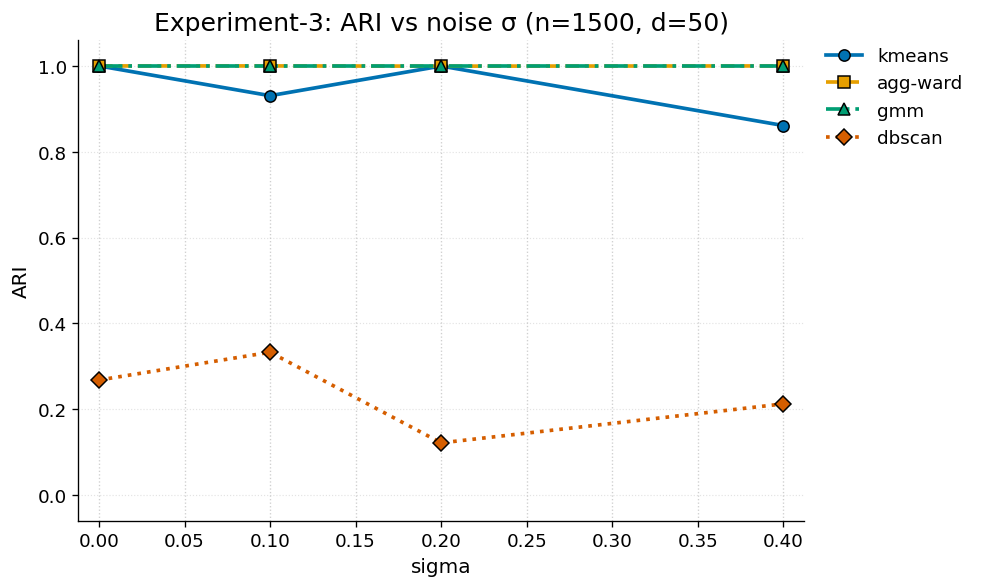

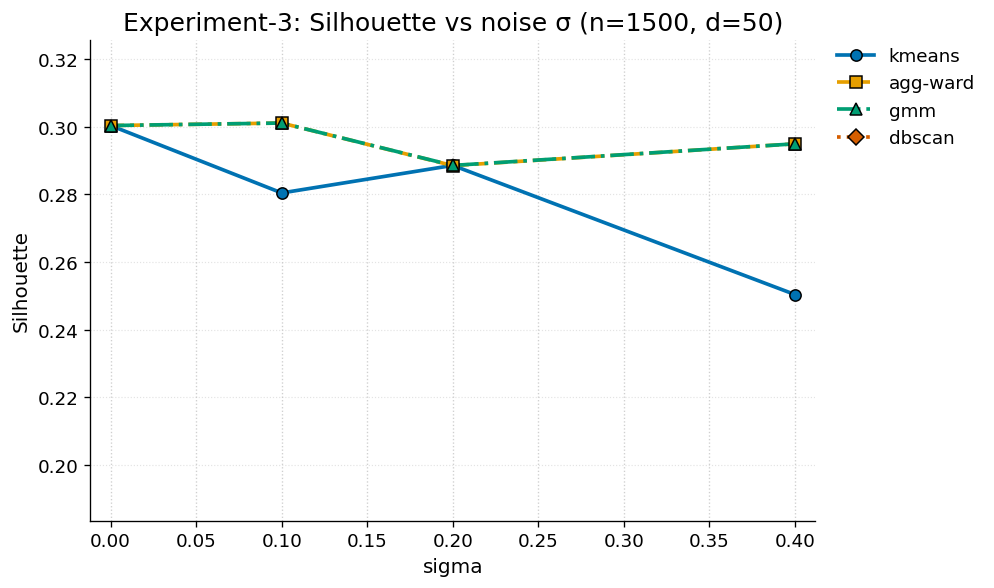

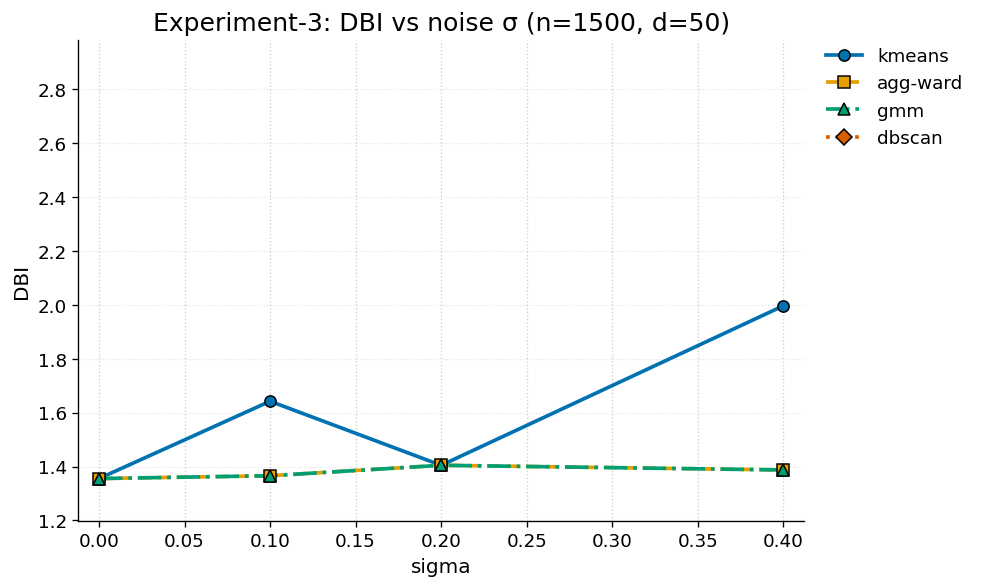

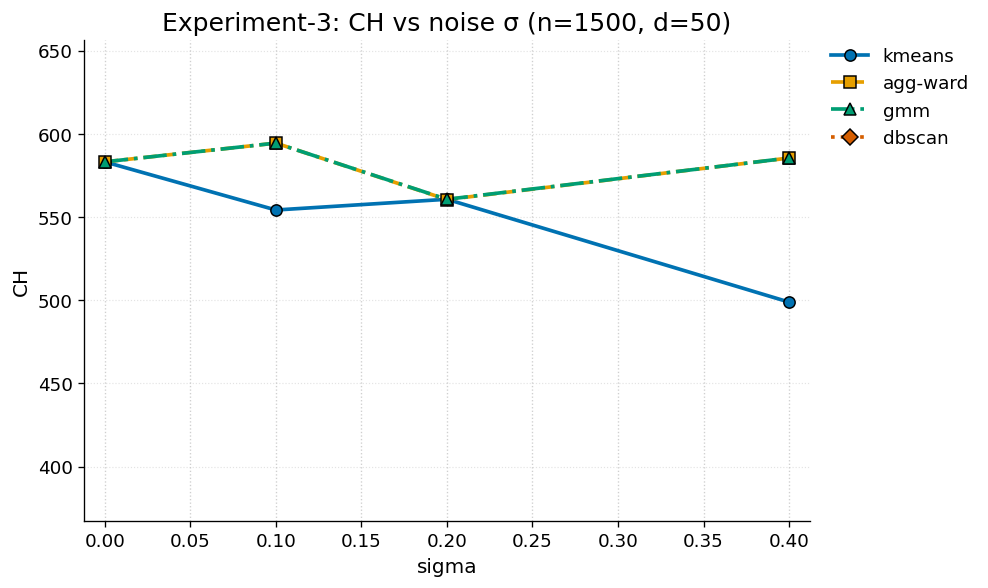

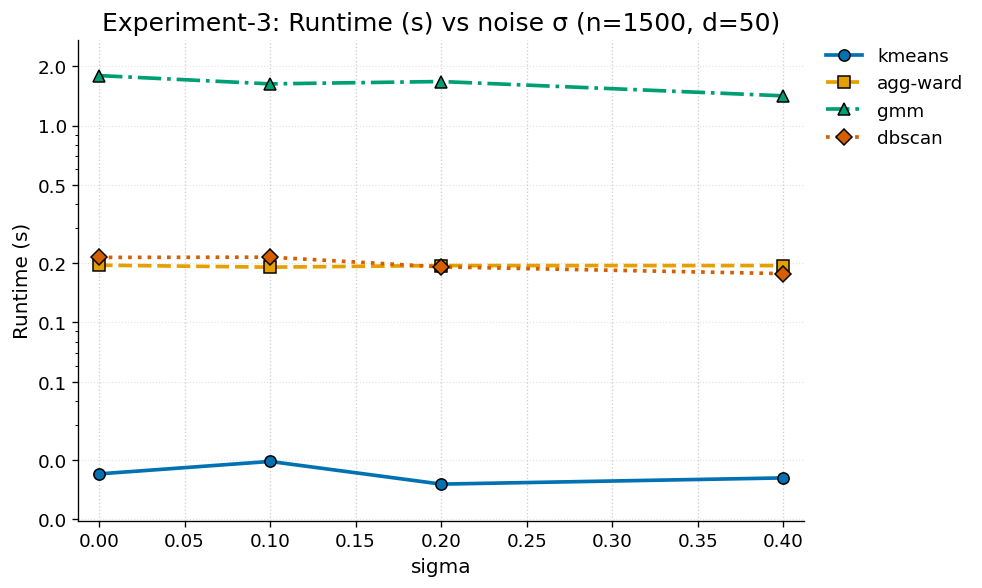

In [35]:

# Experiment — Feature noise also called sigma
n_features = 50
n_samples = 1500
n_clusters = 3
std = 1.6
sigmas = [0.0, 0.1, 0.2, 0.4]

rows = []
for s in sigmas:
    for r in range(REPEATS):
        seed = RANDOM_SEED + 3000*r + int(100*s)
        X_base, y = create_stretched_out_blobs(n_samples=n_samples, n_features=n_features,
                                               n_clusters=n_clusters, cluster_std=std,
                                               center_scale=3.0, aniso_strength=4.0, seed=seed)
        Xn = add_feature_noise(X_base, sigma=s, seed=seed)
        runs, _ = run_clustering_methods(Xn, n_clusters=n_clusters, seed=seed)
        for rec in evaluate_methods_standard(Xn, y, runs):
            rows.append({"repeat": r, "sigma": s, **rec})

exp3_df = pd.DataFrame(rows)
show_table(exp3_df, "Experiment-3: Raw repeats (all metrics)")

exp3_sum = summarize_with_ci(exp3_df, key_col="sigma", method_col="method",
                             value_cols=["ARI","Silhouette","DBI","CH","runtime_s"])
show_table(exp3_sum.sort_values(["method","sigma"]), "Experiment-3: Summary (mean±CI cols)")

exp3_p = pairwise_pvals(exp3_df, key_col="sigma", method_col="method",
                        metric_col="ARI", methods=["kmeans","agg-ward","gmm","dbscan"])
show_table(exp3_p.sort_values(["metric","method_a","method_b","sigma"]), "Experiment-3: Pairwise p-values (ARI)")

def _line_ci_exp3(metric, ylab, log_y=False):
    fig, ax = plt.subplots(figsize=(7.8,5.2))
    for m in ["kmeans","agg-ward","gmm","dbscan"]:
        stats = exp3_sum[exp3_sum["method"]==m].copy().sort_values("sigma")
        plot_with_ci(ax, stats["sigma"].values, stats, "sigma", metric, m,
                     palette[m], linestyles[m], markers[m])
    ax.set_title(f"Experiment-3: {ylab} vs noise σ (n=1500, d=50)")
    ax.set_xlabel("sigma"); ax.set_ylabel(ylab)
    style_axes(ax, log_y=log_y); add_method_legend(ax); plt.show()

_line_ci_exp3("ARI","ARI")
_line_ci_exp3("Silhouette","Silhouette")
_line_ci_exp3("DBI","DBI")
_line_ci_exp3("CH","CH")
_line_ci_exp3("runtime_s","Runtime (s)", log_y=True)


D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread


Experiment-P: Raw repeats (all metrics)
 repeat setting  target_dim   method       ARI  Silhouette      DBI           CH  runtime_s
      0     raw          50   kmeans  1.000000    0.256202 1.543640   453.974160   0.015464
      0     raw          50 agg-ward  1.000000    0.256202 1.543640   453.974160   0.192714
      0     raw          50      gmm  1.000000    0.256202 1.543640   453.974160   1.867508
      0     raw          50   dbscan  0.000000         NaN      NaN          NaN   0.239917
      1     raw          50   kmeans  1.000000    0.329584 1.242510   666.181533   0.027413
      1     raw          50 agg-ward  1.000000    0.329584 1.242510   666.181533   0.238208
      1     raw          50      gmm  1.000000    0.329584 1.242510   666.181533   1.548500
      1     raw          50   dbscan  0.000000         NaN      NaN          NaN   0.240572
      2     raw          50   kmeans  1.000000    0.280109 1.436025   527.832801   0.015840
      2     raw          50 agg-ward  1

C:\Users\subru\AppData\Local\Temp\ipykernel_33488\3592974614.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for key, subk in df.groupby(key_col):



Experiment-P: Summary (mean±CI cols)
setting   method  ARI_mean   ARI_lo   ARI_hi  Silhouette_mean  Silhouette_lo  Silhouette_hi  DBI_mean   DBI_lo   DBI_hi      CH_mean        CH_lo        CH_hi  runtime_s_mean  runtime_s_lo  runtime_s_hi
  pca10 agg-ward  1.000000 1.000000 1.000000         0.508904       0.494190       0.524683  0.778166 0.742354 0.813153  1724.723251  1582.128230  1879.025875        0.153232      0.149053      0.156205
   pca2 agg-ward  0.999750 0.999250 1.000000         0.801910       0.791800       0.809358  0.274516 0.261897 0.291157 11830.062791 10865.288885 12744.444313        0.129200      0.124707      0.134137
    raw agg-ward  1.000000 1.000000 1.000000         0.296340       0.280357       0.311929  1.373578 1.312570 1.441261   573.081972   517.099647   626.215646        0.199341      0.188792      0.213264
  pca10   dbscan  0.976989 0.973983 0.980279         0.512779       0.498118       0.528788  0.770396 0.737543 0.803414  1739.392269  1599.096116  188

C:\Users\subru\AppData\Local\Temp\ipykernel_33488\3592974614.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for key, subk in df.groupby(key_col):



Experiment-P: Pairwise p-values (ARI)
setting metric method_a method_b  p_value
  pca10    ARI agg-ward   dbscan 0.006799
   pca2    ARI agg-ward   dbscan 0.008099
    raw    ARI agg-ward   dbscan 0.007499
  pca10    ARI agg-ward      gmm 1.000000
   pca2    ARI agg-ward      gmm 1.000000
    raw    ARI agg-ward      gmm 1.000000
  pca10    ARI      gmm   dbscan 0.007599
   pca2    ARI      gmm   dbscan 0.009399
    raw    ARI      gmm   dbscan 0.007399
  pca10    ARI   kmeans agg-ward 1.000000
   pca2    ARI   kmeans agg-ward 1.000000
    raw    ARI   kmeans agg-ward 1.000000
  pca10    ARI   kmeans   dbscan 0.008199
   pca2    ARI   kmeans   dbscan 0.006699
    raw    ARI   kmeans   dbscan 0.037896
  pca10    ARI   kmeans      gmm 1.000000
   pca2    ARI   kmeans      gmm 1.000000
    raw    ARI   kmeans      gmm 1.000000


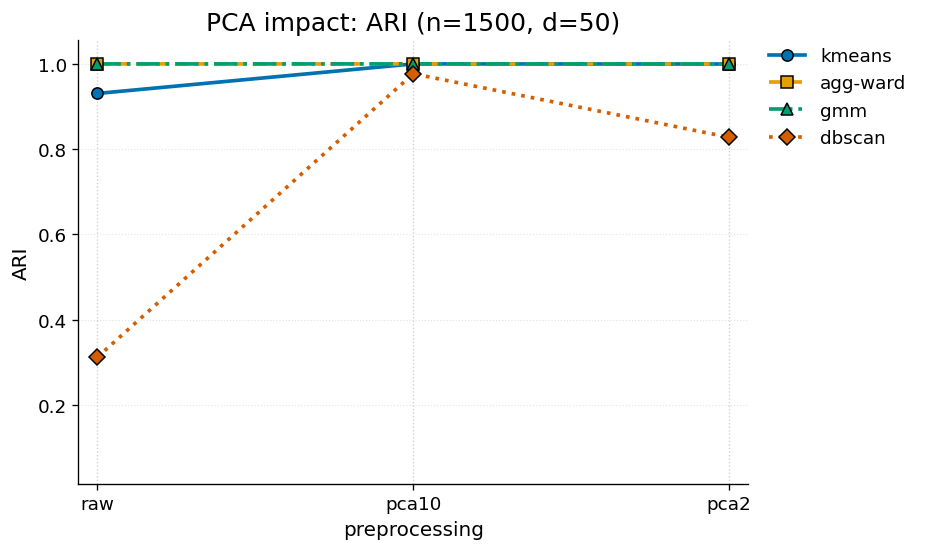

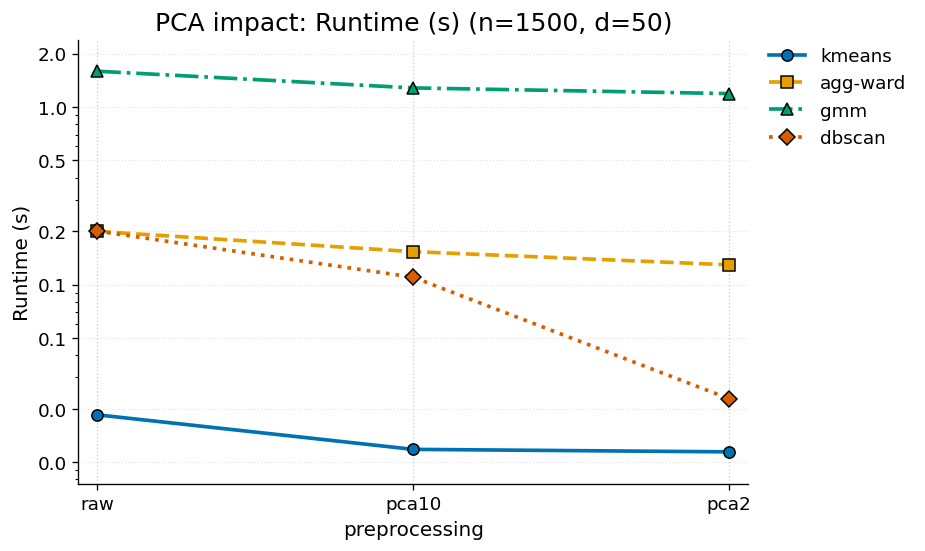

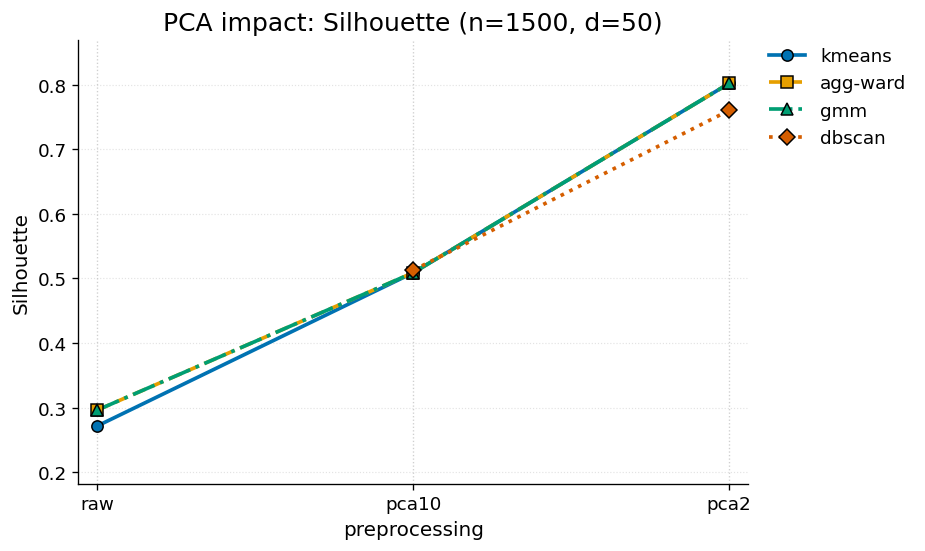

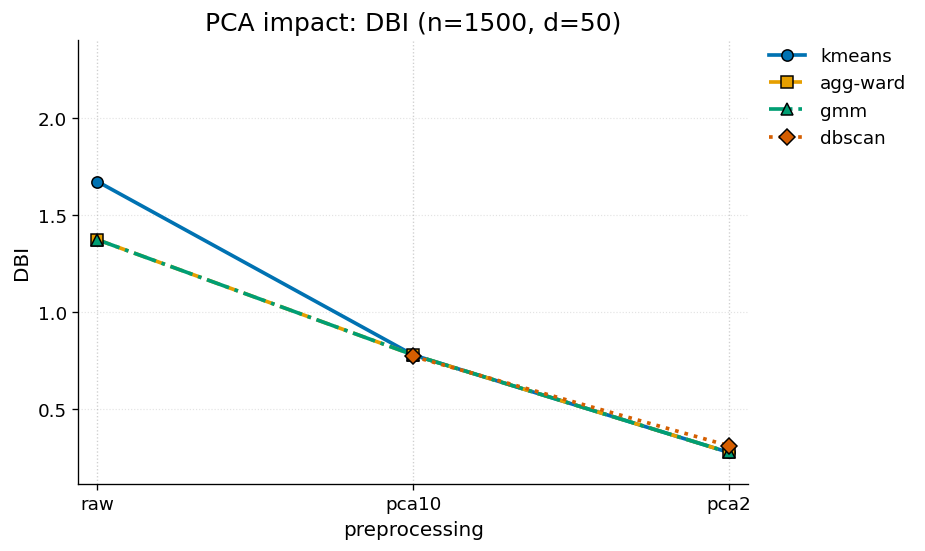

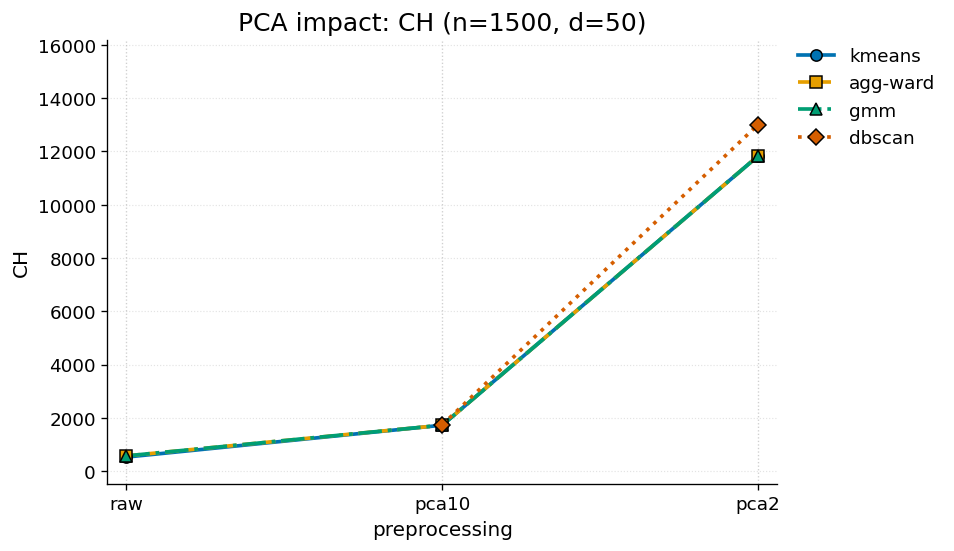

In [36]:

# Experiment for PCA impact (raw vs PCA-10 vs PCA-2) fixed dataset
n_samples = 1500
n_features = 50
n_clusters = 3
std = 1.6

settings = [("raw", None, 0), ("pca10", 10, 10), ("pca2", 2, 2)]
rows = []

for label, target_dim, offset in settings:
    for r in range(REPEATS):
        seed = RANDOM_SEED + 4000*r + offset
        X, y = create_stretched_out_blobs(n_samples=n_samples, n_features=n_features,
                                          n_clusters=n_clusters, cluster_std=std,
                                          center_scale=3.0, aniso_strength=4.0, seed=seed)
        X_use = X if target_dim is None else PCA(n_components=target_dim, random_state=seed).fit_transform(X)
        runs, _ = run_clustering_methods(X_use, n_clusters=n_clusters, seed=seed)
        for rec in evaluate_methods_standard(X_use, y, runs):
            rows.append({"repeat": r, "setting": label,
                        "target_dim": target_dim if target_dim else n_features, **rec})

expP_df = pd.DataFrame(rows)
show_table(expP_df, "Experiment-P: Raw repeats (all metrics)")

order = pd.CategoricalDtype(categories=["raw", "pca10", "pca2"], ordered=True)
expP_df["setting"] = expP_df["setting"].astype(order)

expP_sum = summarize_with_ci(expP_df, key_col="setting", method_col="method",
                             value_cols=["ARI","Silhouette","DBI","CH","runtime_s"])
show_table(expP_sum.sort_values(["method","setting"]), "Experiment-P: Summary (mean±CI cols)")

expP_p = pairwise_pvals(expP_df, key_col="setting", method_col="method",
                        metric_col="ARI", methods=["kmeans","agg-ward","gmm","dbscan"])
show_table(expP_p.sort_values(["metric","method_a","method_b","setting"]), "Experiment-P: Pairwise p-values (ARI)")

def _plot_metric(metric, ylab, log_y=False):
    fig, ax = plt.subplots(figsize=(7.2,4.8))
    for method in ["kmeans","agg-ward","gmm","dbscan"]:
        sub = expP_sum[expP_sum["method"]==method].copy()
        sub["setting"] = sub["setting"].astype(order)
        sub = sub.sort_values("setting")
        plot_with_ci(ax, sub["setting"].values, sub, "setting", metric, method,
                     palette[method], linestyles[method], markers[method])
    ax.set_title(f"PCA impact: {ylab} (n=1500, d=50)")
    ax.set_xlabel("preprocessing"); ax.set_ylabel(ylab)
    style_axes(ax, log_y=log_y); add_method_legend(ax); plt.show()

_plot_metric("ARI","ARI")
_plot_metric("runtime_s","Runtime (s)", log_y=True)
_plot_metric("Silhouette","Silhouette")
_plot_metric("DBI","DBI")
_plot_metric("CH","CH")



Silhouette parity: sklearn vs manual
 dim  sklearn   manual    t_skl    t_man
   2 0.749507 0.749507 0.054567 0.073681
  20 0.724328 0.724328 0.064055 0.084130
 100 0.742345 0.742345 0.060075 0.080029
 500 0.733750 0.733750 0.092514 0.093464


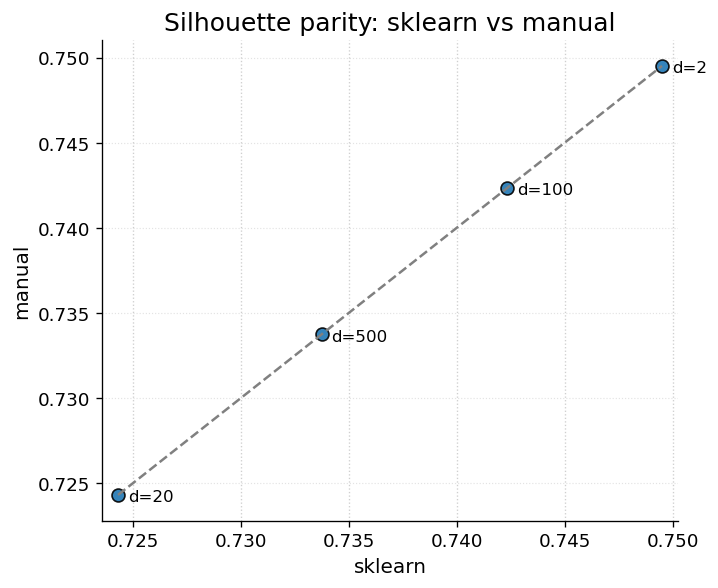

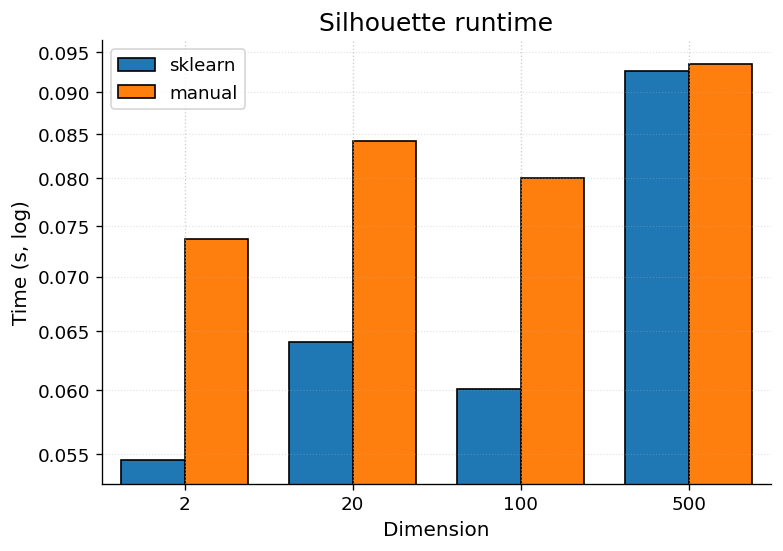

In [37]:

# Silhouette parity: sklearn vs manual implementation
def manual_silhouette(X: np.ndarray, labels: np.ndarray) -> float:
    labs = np.asarray(labels)
    if X.shape[0] < 2 or len(np.unique(labs)) < 2:
        return np.nan
    D = pairwise_distances(X, metric="euclidean").astype(np.float32, copy=False)
    np.fill_diagonal(D, 0.0)
    n = X.shape[0]
    clusters = [np.where(labs == c)[0] for c in np.unique(labs)]
    a = np.zeros(n, dtype=np.float32)
    b = np.full(n, np.inf, dtype=np.float32)
    for ci, idx in enumerate(clusters):
        m = len(idx)
        if m <= 1:
            a[idx] = 0.0
        else:
            sub = D[np.ix_(idx, idx)]
            a[idx] = sub.sum(axis=1) / (m - 1)
        bi = np.full(m, np.inf, dtype=np.float32)
        for cj, jdx in enumerate(clusters):
            if cj == ci: continue
            cross = D[np.ix_(idx, jdx)]
            bi = np.minimum(bi, cross.mean(axis=1).astype(np.float32))
        b[idx] = bi
    s = (b - a) / np.maximum(a, b)
    return float(np.nanmean(s))

dims = [2, 20, 100, 500]
rows = []
for d in dims:
    X, _ = make_blobs(n_samples=1500, centers=3, n_features=d,
                      cluster_std=1.6, random_state=RANDOM_SEED)
    labels = KMeans(n_clusters=3, n_init="auto", algorithm="elkan",
                    max_iter=500, random_state=RANDOM_SEED).fit_predict(X)
    t0 = now(); s_skl = silhouette_score(X, labels); t_skl = now() - t0
    t0 = now(); s_man = manual_silhouette(X, labels); t_man = now() - t0
    rows.append({"dim": d, "sklearn": s_skl, "manual": s_man, "t_skl": t_skl, "t_man": t_man})

sil_df = pd.DataFrame(rows)
show_table(sil_df, "Silhouette parity: sklearn vs manual")

# Scatter parity
fig, ax = plt.subplots(figsize=(6.2,5.2))
ax.scatter(sil_df["sklearn"], sil_df["manual"], s=60, edgecolor="black", alpha=0.9)
for _, r in sil_df.iterrows():
    ax.annotate(f"d={int(r['dim'])}", (r["sklearn"], r["manual"]), textcoords="offset points", xytext=(6,-4), fontsize=10)
lo = min(sil_df["sklearn"].min(), sil_df["manual"].min())
hi = max(sil_df["sklearn"].max(), sil_df["manual"].max())
ax.plot([lo, hi], [lo, hi], "--", color="gray")
ax.set_title("Silhouette parity: sklearn vs manual")
ax.set_xlabel("sklearn"); ax.set_ylabel("manual"); style_axes(ax); plt.show()

# Runtime bars (log y)
fig, ax = plt.subplots(figsize=(7.2,4.8))
x = np.arange(len(dims)); w = 0.38
ax.bar(x - w/2, sil_df["t_skl"], width=w, edgecolor="black", label="sklearn")
ax.bar(x + w/2, sil_df["t_man"], width=w, edgecolor="black", label="manual")
ax.set_xticks(x); ax.set_xticklabels([str(d) for d in dims])
ax.set_title("Silhouette runtime"); ax.set_xlabel("Dimension"); ax.set_ylabel("Time (s, log)")
style_axes(ax, log_y=True); ax.legend(); plt.show()


In [39]:

# Bootstrap validation with mean , median, quantiles etc..
def _iqr_stats(series):
    q25 = np.quantile(series, 0.25)
    q75 = np.quantile(series, 0.75)
    return q25, q75, q75 - q25

n_features=50; n_samples=1500; n_clusters=3; std=1.6
seed = RANDOM_SEED + 777
X, y = create_stretched_out_blobs(n_samples, n_features, n_clusters,
                                  cluster_std=std, center_scale=3.0,
                                  aniso_strength=4.0, seed=seed)
rows=[]
rs = np.random.default_rng(seed)
for b in range(BOOT_SAMPLES_B):
    idx = rs.integers(0, len(X), size=len(X))
    Xb, yb = X[idx], y[idx]
    runs, _ = run_clustering_methods(Xb, n_clusters=n_clusters, seed=seed+b)
    for name, lab, _ in runs:
        rows.append({"bootstrap":b, "method":name, "ARI":adjusted_rand_score(yb, lab)})

boot_df = pd.DataFrame(rows)
show_table(boot_df.sort_values(["method","bootstrap"]), "Bootstrap base: ARI per sample")

g = boot_df.groupby("method")["ARI"]
rows2=[]
for m, s in g:
    s = np.asarray(s, float)
    q25, q75, iqr = _iqr_stats(s)
    rows2.append({
        "method": m,
        "mean":   float(s.mean()),
        "std":    float(s.std(ddof=1)),
        "median": float(np.median(s)),
        "q25":    float(q25),
        "q75":    float(q75),
        "IQR":    float(iqr),
        "p05":    float(np.quantile(s, 0.05)),
        "p95":    float(np.quantile(s, 0.95)),
        "min":    float(s.min()),
        "max":    float(s.max()),
        "n_boot": int(len(s)),
    })
boot_sum = pd.DataFrame(rows2).sort_values("method")
show_table(boot_sum, "Bootstrap base: ARI summary by method")


D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread


Bootstrap base: ARI per sample
 bootstrap   method           ARI
         0 agg-ward  1.000000e+00
         1 agg-ward  1.000000e+00
         2 agg-ward  1.000000e+00
         3 agg-ward  1.000000e+00
         4 agg-ward  1.000000e+00
         5 agg-ward  1.000000e+00
         6 agg-ward  1.000000e+00
         7 agg-ward  1.000000e+00
         8 agg-ward  1.000000e+00
         9 agg-ward  1.000000e+00
        10 agg-ward  1.000000e+00
        11 agg-ward  1.000000e+00
        12 agg-ward  1.000000e+00
        13 agg-ward  1.000000e+00
        14 agg-ward  1.000000e+00
        15 agg-ward  1.000000e+00
        16 agg-ward  1.000000e+00
        17 agg-ward  1.000000e+00
        18 agg-ward  1.000000e+00
        19 agg-ward  1.000000e+00
        20 agg-ward  1.000000e+00
        21 agg-ward  1.000000e+00
        22 agg-ward  1.000000e+00
        23 agg-ward  1.000000e+00
        24 agg-ward  1.000000e+00
        25 agg-ward  1.000000e+00
        26 agg-ward  1.000000e+00
        27 agg-w